In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/marketing_campaign.csv", sep = '\t')

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
df.shape

(2240, 29)


# Clean data

In [6]:
df.isnull().sum().head().sum()

24

In [7]:
### Quitar columnas que no sirven
df=df.drop(columns=["Z_CostContact", "Z_Revenue"],axis=1)

In [8]:
### Los valores nulos venian de la columna income. Lo que hice fue rellenarlos con el valor mediano de la distribucion
df['Income']=df['Income'].fillna(df['Income'].median())

In [9]:
df.isnull().sum().head().sum()

0

In [10]:
df['Marital_Status'].unique()

# Creo que algunas variables sobran así que voy a reformar cada cosa

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [11]:
df['Marital_Status'] = df['Marital_Status'].replace(['Together'],'FreeUnion')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'],'Single')

Con esto hago una distincion importante. Separo en tres grupos: los casados, los solteros y los que tienen una relacion libre. 

In [12]:
df['Marital_Status'].unique()

array(['Single', 'FreeUnion', 'Married'], dtype=object)

In [13]:
### En este gran apartado solo estoy creando columnas producto de la suma de varias columnas. Con esto evito tanto dato.

df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['TotalAcceptedCMP'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']
df['NumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

In [14]:
### Con esto creo un diccionario que despues elimino 
col_del = ["AcceptedCmp1" , "AcceptedCmp2", "AcceptedCmp3" , "AcceptedCmp4","AcceptedCmp5", "Response","NumWebVisitsMonth", "NumWebPurchases","NumCatalogPurchases","NumStorePurchases","NumDealsPurchases" , "Kidhome", "Teenhome","MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
df=df.drop(columns=col_del,axis=1)

In [15]:
## Hora de ver el resultado! 
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Dt_Customer,Recency,Complain,Kids,Expenses,TotalAcceptedCMP,NumPurchases
0,5524,1957,Graduation,Single,58138.0,04-09-2012,58,0,0,1617,1,25
1,2174,1954,Graduation,Single,46344.0,08-03-2014,38,0,2,27,0,6
2,4141,1965,Graduation,FreeUnion,71613.0,21-08-2013,26,0,0,776,0,21
3,6182,1984,Graduation,FreeUnion,26646.0,10-02-2014,26,0,1,53,0,8
4,5324,1981,PhD,Married,58293.0,19-01-2014,94,0,1,422,0,19


In [16]:
### Lo ultimo que quiero hacer es cambiar algunas variables de education
df['Education'] = df['Education'].replace(['2n Cycle','Graduation', ],'Graduate')  
df['Education'] = df['Education'].replace(['Basic'], 'UnderGraduate')

# Data analysis

### Approach 

1. Aislar variables
    - Year_Birth 
    - Education 
    - Marital Status
    - Income
    - Kids
    
    
    
2. Relacionar variables
    

In [17]:
(
df["Education"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

Graduate         59.4%
PhD              21.7%
Master           16.5%
UnderGraduate     2.4%
Name: Education, dtype: object

In [18]:
(
df["Marital_Status"]
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

Married      38.6%
Single       35.5%
FreeUnion    25.9%
Name: Marital_Status, dtype: object

Text(0, 0.5, 'Acumulacion')

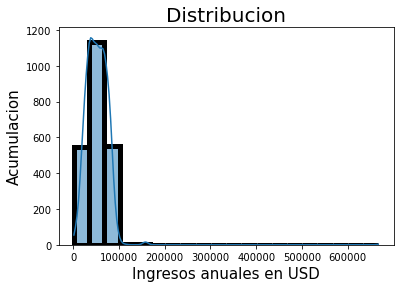

In [29]:
IncomeHist = sns.histplot(
            df, 
            x="Income",
            bins=20,
            linewidth=5, 
            kde = True)

IncomeHist.set_title("Distribucion", fontsize = 20)
IncomeHist.set_xlabel("Ingresos anuales en USD", fontsize = 15)
IncomeHist.set_ylabel("Acumulacion", fontsize = 15)

Text(0, 0.5, 'Acumulacion')

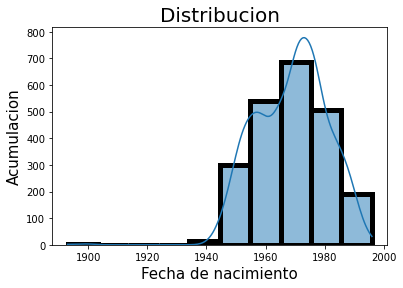

In [30]:
NacimientoHist = sns.histplot(
            df, 
            x="Year_Birth",
            bins=10,
            linewidth=5, 
            kde = True)

NacimientoHist.set_title("Distribucion", fontsize = 20)
NacimientoHist.set_xlabel("Fecha de nacimiento", fontsize = 15)
NacimientoHist.set_ylabel("Acumulacion", fontsize = 15)

https://www.kaggle.com/imakash3011/customer-personality-analysis